In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Data Preparation

In [2]:
import zipfile
import os

# Ensure the target directory exists on Google Drive
target_dir = '/content/drive/My Drive/INM705/CW/dataset'
os.makedirs(target_dir, exist_ok=True)

# Zip file location
zip_path = '/content/drive/My Drive/INM705-CW.zip'

# Unzip the dataset into the target directory on Google Drive
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(target_dir)

# Check the contents
print(os.listdir(target_dir))

['__MACOSX', 'INM705-CW']


The following preprocessing steps have been implemented:


1. Rescaling the pixel values from a range of 0-255 to 0-1, normalizing the data.
2. Data Augmentation (for training data only).
3. Batched into groups of 32.
4. Test data loaded with no augmentation besides rescaling to make sure that the evaluation of the model is performed on original, unaltered images from the dataset.



In [13]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# create a data generator for augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

# load images from directories
train_generator = train_datagen.flow_from_directory(
    '/content/dataset/INM705-CW/data/Train',
    target_size=(64, 64),
    batch_size=32,
    class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
    '/content/dataset/INM705-CW/data/Test',
    target_size=(64, 64),
    batch_size=32,
    class_mode='categorical')

Found 1266345 images belonging to 14 classes.
Found 111308 images belonging to 14 classes.


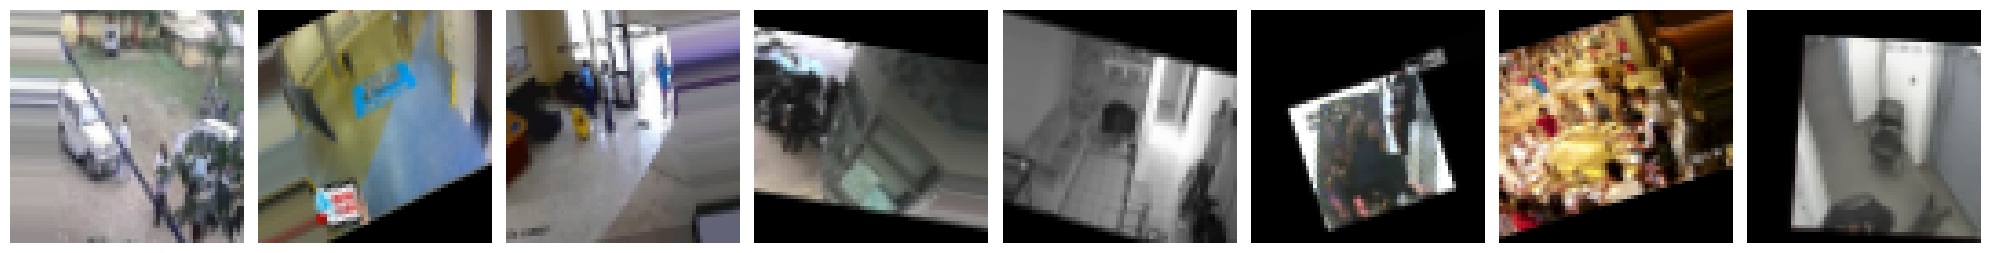

In [9]:
import matplotlib.pyplot as plt

def plot_images(images_arr):
    fig, axes = plt.subplots(1, 8, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

images, labels = next(train_generator)

# plot the images
plot_images(images)

### Spatial Feature Extraction (using pre-trained ResNet)

In [22]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2

# load ResNet50 pre-trained on ImageNet
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(64, 64, 3))
base_model.trainable = False  # freeze the convolutional base

# add custom simplified layers on top of ResNet
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu', kernel_regularizer=l2(0.01))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
predictions = Dense(14, activation='softmax')(x)

# create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# model summary to see the effects of changes
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5             │ (None, 64, 64, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 70, 70, 3)      │              0 │ input_layer_5[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 32, 32, 64)     │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 32, 32, 64)     │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 32, 32, 64)     │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 34, 34, 64)     │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 16, 16, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 16, 16, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 16, 16, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 16, 16, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 16, 16, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 16, 16, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 16, 16, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 16, 16, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 16, 16, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 25,704,334 (98.05 MB)

 Trainable params: 2,114,574 (8.07 MB)

 Non-trainable params: 23,589,760 (89.99 MB)

#### Train model

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# define checkpointing
checkpoint_path = '/content/drive/My Drive/INM705/CW/Model_Checkpoints/spatial-model-{epoch:02d}-{val_loss:.2f}.keras'
checkpoint = ModelCheckpoint(filepath=checkpoint_path, save_best_only=True, verbose=1, monitor='val_loss', mode='min')

# define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='min')

# train model with checkpoint and early stopping
history = model.fit(
    train_generator,
    epochs=25,
    validation_data=test_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_steps=test_generator.samples // test_generator.batch_size,
    callbacks=[checkpoint, early_stopping]
)

Epoch 1/25
39573/39573 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.7430 - loss: 1.2206
Epoch 1: val_loss improved from inf to 2.66431, saving model to /content/drive/My Drive/INM705/CW/Model_Checkpoints/spatial-model-01-2.66.keras
39573/39573 ━━━━━━━━━━━━━━━━━━━━ 4446s 110ms/step - accuracy: 0.7430 - loss: 1.2206 - val_accuracy: 0.2875 - val_loss: 2.6643
Epoch 2/25
    1/39573 ━━━━━━━━━━━━━━━━━━━━ 15:53 24ms/step - accuracy: 0.8125 - loss: 0.9371

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_loss improved from 2.66431 to 2.65023, saving model to /content/drive/My Drive/INM705/CW/Model_Checkpoints/spatial-model-02-2.65.keras
39573/39573 ━━━━━━━━━━━━━━━━━━━━ 70s 2ms/step - accuracy: 0.8125 - loss: 0.9371 - val_accuracy: 0.2936 - val_loss: 2.6502
Epoch 3/25
39573/39573 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 0.7484 - loss: 1.1111
Epoch 3: val_loss improved from 2.65023 to 2.32880, saving model to /content/drive/My Drive/INM705/CW/Model_Checkpoints/spatial-model-03-2.33.keras
39573/39573 ━━━━━━━━━━━━━━━━━━━━ 4344s 109ms/step - accuracy: 0.7484 - loss: 1.1111 - val_accuracy: 0.5159 - val_loss: 2.3288
Epoch 4/25
    1/39573 ━━━━━━━━━━━━━━━━━━━━ 14:23 22ms/step - accuracy: 0.7188 - loss: 1.0941
Epoch 4: val_loss did not improve from 2.32880
39573/39573 ━━━━━━━━━━━━━━━━━━━━ 64s 2ms/step - accuracy: 0.7188 - loss: 1.0941 - val_accuracy: 0.4644 - val_loss: 2.3464
Epoch 5/25
 1191/39573 ━━━━━━━━━━━━━━━━━━━━ 1:14:48 117ms/step - accuracy: 0.7485 - loss: 1.1054